In [1]:
import torch
from lichi import LIChI
import matplotlib.pyplot as plt
from torchvision.io import read_image, write_png
import scipy.io as sio
import seaborn as sns
import pandas as pd
import piq
import pyiqa
niqe = pyiqa.create_metric('niqe')

C:\Users\lwenxin\.lichi_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# parameters
sigma = 5
m_lichi = LIChI() 

In [3]:
# Load images
mat_data = sio.loadmat('.\\MRIdata\\humanMRI.mat')
alldata = mat_data['save_data']# use one slice & one time point 
# Storage for metrics
metrics = {'BRISQUE': {'Noisy': [], 'Denoised': []},
    'NIQE': {'Noisy': [], 'Denoised': []}}

for slice in range(alldata.shape[2]):
    data = alldata[:,:,slice,1]
    data = data*255 # normalize the image to [0,255]
    img = torch.from_numpy(data).float().unsqueeze(0).unsqueeze(0) 
    # denoising
    x_hat = m_lichi(img, sigma=sigma, constraints='affine', method='noisy', p1=3, p2=3, k1=8, k2=24, w=25, s=3, M=9)
    
    # Convert to float tensor and normalize to [0, 1]
    noisy_img = img.float() / 255.0  
    noisy_img = torch.clamp(noisy_img, 0.0, 1.0)
    denoised_img = x_hat.float() / 255.0 
    denoised_img = torch.clamp(denoised_img, 0.0, 1.0)
    
    # Compute metrics
    # BRISQUE
    metrics['BRISQUE']['Noisy'].append(piq.brisque(noisy_img).item())
    metrics['BRISQUE']['Denoised'].append(piq.brisque(denoised_img).item())
    
    # NIQE
    metrics['NIQE']['Noisy'].append(niqe(noisy_img).item())
    metrics['NIQE']['Denoised'].append(niqe(denoised_img).item())

C:\Users\lwenxin\AppData\Local\Temp\ipykernel_18652\738582743.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


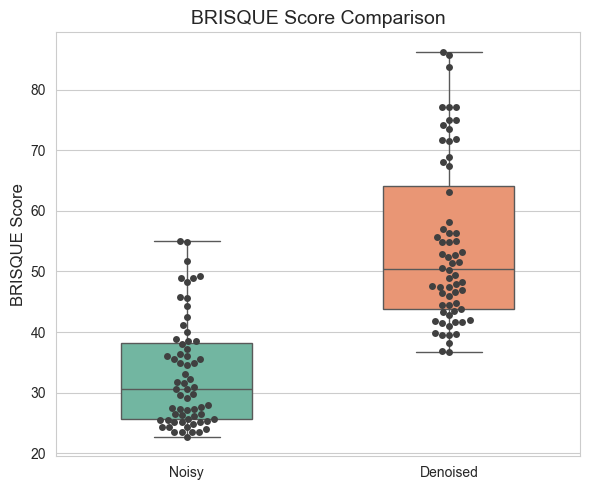

p = 0.000 (***)


C:\Users\lwenxin\AppData\Local\Temp\ipykernel_18652\738582743.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


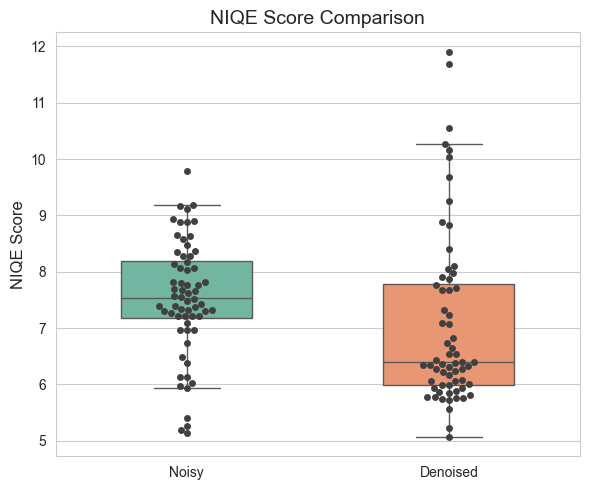

p = 0.003 (**)


In [13]:
# box plot
from scipy.stats import wilcoxon
df_list = []
for metric_name, conditions in metrics.items():
    for condition, values in conditions.items():
        for value in values:
            df_list.append({'Metric': metric_name,'Condition': condition,'Value': value})
df = pd.DataFrame(df_list)

metrics_to_plot = ['BRISQUE', 'NIQE']

for metric in metrics_to_plot:
    plt.figure(figsize=(6, 5))
    sns.set_style("whitegrid")
    
    metric_df = df[df['Metric'] == metric]
    
    # Create boxplot
    ax = sns.boxplot(
        x='Condition',
        y='Value',
        data=metric_df,
        palette="Set2",
        width=0.5,
        showfliers=False
    )
    
    # Add swarm plot
    sns.swarmplot(
        x='Condition',
        y='Value',
        data=metric_df,
        color=".25",
        size=5,
        ax=ax
    )

    # Perform Wilcoxon signed-rank test
    noisy_vals = metric_df[metric_df['Condition'] == 'Noisy']['Value'].values
    denoised_vals = metric_df[metric_df['Condition'] == 'Denoised']['Value'].values
    
    stat, p_value = wilcoxon(noisy_vals, denoised_vals)
    
    if p_value < 0.001:
        sig_symbol = '***'
    elif p_value < 0.01:
        sig_symbol = '**'
    elif p_value < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'ns'
    
    plt.title(f"{metric} Score Comparison", fontsize=14)
    plt.xlabel("")
    plt.ylabel(f"{metric} Score", fontsize=12)
    plt.tight_layout()
    plt.show()
    print(f'p = {p_value:.3f} ({sig_symbol})')